# Random interfaces

The final result of Rob's calculation is that an interface should obey the probability distribution

$$P(\rm curve)\propto \Pi_{n=1}^K \exp\left[\dfrac{\pi^2\gamma}{8 R\phi T}a_n (n^2-1)\right]$$

Tis should provide a recipe to generate 

$$r(\theta) = R+ \sum_{n=1}^K a_n \sin\left(\dfrac{n\pi}{2\phi}(\theta+\phi)\right)$$

Here is a simple implementation.

In [145]:
import numpy as np


def generate_curve(R = 1.0, energy = 1.0, phi = np.pi/2., K = 100,ntheta = 50):
    """
    Generate a random interface.
    
    Parameteres:
        R: radius
        energy: gamma/T
        phi: half-angle
        K: Fourier knots
        ntheta: number of angular evaluations
    """
    
    ns = np.arange(2,K+1, dtype=int)
    variances = 2./( np.pi**2*energy/(8*R*phi)*(ns**2-1))
    stds = np.sqrt(variances)
    # generate all coefficients n>=2
    a2s  = np.random.normal(np.zeros(K-1),stds)

#     a1 = 0
#     a1 = np.sqrt(np.sum)
    odds = np.arange(3,K+1,2)
    sumodd = 2*R* np.sum(4*a2s[1::2]/odds/np.pi)
    C = np.sum(a2s**2)+sumodd
    b2m4ac = 16*R**2/np.pi**2-C
    print(b2m4ac)
    assert b2m4ac>0, "Problems inside the sqrt"
    a1 = -4*R/np.pi-np.sqrt(b2m4ac)
    a = np.concatenate([[a1],a2s]) 
    n = np.concatenate([[1],ns]) 
    #  sample n-2 coefficients
    assert len(a)==K, "Incorrect lengths"

    # generate theta range
    theta = np.linspace(-phi,phi,ntheta)
    # calculate sine argument
    prod = np.multiply.outer((theta+phi),np.pi*n/(2*phi))
    r = np.ones(ntheta)*R+(a*np.sin(prod)).sum(axis=1)
    
    #impose boundaries
    r[0]=r[-1] = 0
    # get Cartesian coordinates
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x, y,r,theta

We then generate some paths

100%|██████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 26.00it/s]


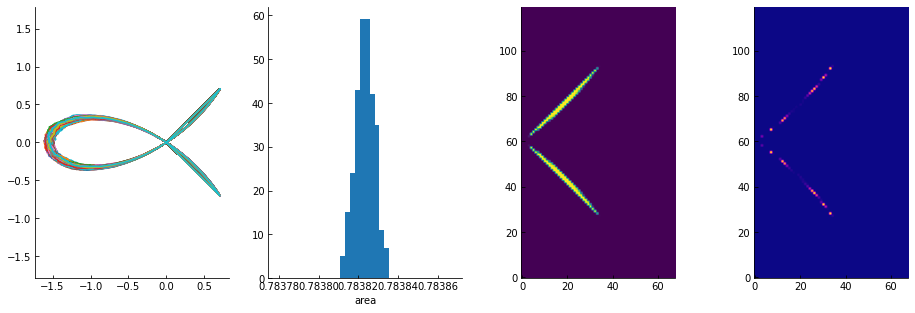

In [148]:
## import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import matplotlib.path as mpltPath
import tqdm 

areas = []
rhos = []
fig,ax = plt.subplots(1,4, figsize=(16,5))
dx = dy = 0.02
xlo = 0.0
xhi = 1.35
ylo =  -1.2
yhi = 1.2
gridx,gridy = np.mgrid[xlo:xhi:dx,ylo:yhi:dy]

for k in tqdm.tqdm(range(300)):
    x,y,r,theta  = generate_curve(phi= np.pi/4, energy = 500, K=1000, ntheta=1000)
    ax[0].plot(x,y)
    shape = Polygon([(xx,yy) for xx,yy in zip(x,y)])
    areas.append(shape.area)
    
    #use faster matplotlib function to check grid
    polygon = np.array([x,y]).T
    path = mpltPath.Path(polygon)
    points = np.array([gridx.ravel(),gridy.ravel()]).T
    contained = path.contains_points(points)
    rhos.append(contained.astype(np.float32).reshape(gridx.shape))
    # second estimate of the area from the grid
    area_from_ratio = contained.sum()/len(contained)*(xhi-xlo)*(yhi-ylo)
#     print(shape.area, area_from_ratio)
    
#     
areas = np.array(areas)
ax[0].axis('equal');
ax[1].hist(areas);
ax[1].set_xlim(areas.mean()-10*areas.std(),areas.mean()+10*areas.std())
ax[1].set_xlabel('area')
ax[2].imshow(np.mean(rhos,axis=0).T, origin='lower')
ax[3].imshow(np.var(rhos,axis=0).T, origin='lower', cmap=plt.cm.plasma
            )

plt.savefig("paths.png")

<Figure size 432x288 with 0 Axes>